# Problem set 4

In [713]:
# import all the fun stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

In [714]:
data = np.load("mcmc/sidebands.npz")

In [715]:
t_data = data['time']
d = data['signal']

# adjust t to order unity
# by inspection, interesting stuff
# occurs at t ~ 10^-4:
t = t_data * 1e4

## 1. a)

First, analytically. The analytical derivatives are
\begin{gather}
\frac{\partial d}{\partial a} = \frac{1}{1 + \left(\frac{t-t_0}{w}\right)^2} \\
\frac{\partial d}{\partial t_0} = \frac{2a(t-t_0)}{w^2 \left(1 + \left(\frac{t-t_0}{w}\right)^2\right)^2} \\
\frac{\partial d}{\partial w} = \frac{2a(t-t_0)^2}{w^3 \left(1 + \left(\frac{t-t_0}{w}\right)^2\right)^2}
\end{gather}
Let's run our Newton's method with these!

In [716]:
def calc_lorentz(p,t):
    """
    Returns the function and its analytical gradient as a function
    of model parameters
    t is time
    p is the set of parameters p = {a,t0,w}
    """
    # unpack values
    a, t0, w = p
    
    # evaluate function
    y = a/(1+((t-t0)/w)**2)
    
    # evaluate graident (analytically computed by hand and verified with, e.g. mathematica)
    grad=np.zeros([t.size,p.size])
    
    # w.r.t a
    grad[:,0] = 1.0/(1+((t-t0)/w)**2)
    
    # w.r.t t0
    grad[:,1] = 2*a*(t-t0) / (w * (1+((t-t0)/w)**2))**2
    
    # w.r.t w
    grad[:,2] = 2*a*(t-t0)**2 / (w**3 * (1+((t-t0)/w)**2)**2)
    
    return y, grad

In [717]:
# a is the amplitude ~ 1
# t0 is the mean ~ 0.002 -> 2 after re-scaling
# w is the width ~ 0.001 -> 1 after re-scaling

# initial guess:
p0 = np.array([1., 2., 1.])

In [718]:
def newtons_method(p0,t,d,num,print_params=False):
    """
    Runs Newton's method for initial parameter guess p0
    t an
    d d are the time and data, resp.
    """
    # starting parameters is p0
    p = p0.copy()

    for i in range(num):
        # calculate derivatives and function
        pred, grad = calc_lorentz(p,t)
        
        # delta is difference between data and prediction
        # thanks Jon for the code
        r = d - pred
        err = (r**2).sum()
        r = r.T
        
        lhs=grad.T@grad
        rhs=grad.T@r
        dp=np.linalg.inv(lhs)@(rhs)
        for jj in range(p.size):
            p[jj]=p[jj]+dp[jj]
            
        if print_params:
            print("The parameters are:",p)
            print("The step is:",dp)
    
    return p, dp

In [719]:
num = 12 # seems to do the trick
params, dps = newtons_method(p0=p0,t=t,d=d,num=num,print_params=True)

The parameters are: [0.76785413 1.89433514 0.28446934]
The step is: [-0.23214587 -0.10566486 -0.71553066]
The parameters are: [1.3222158  1.95114333 0.11813508]
The step is: [ 0.55436167  0.05680819 -0.16633426]
The parameters are: [1.35809486 1.92932537 0.179909  ]
The step is: [ 0.03587906 -0.02181796  0.06177392]
The parameters are: [1.42290402 1.92311333 0.17907933]
The step is: [ 0.06480916 -0.00621205 -0.00082967]
The parameters are: [1.42271787 1.92360362 0.17925956]
The step is: [-0.00018615  0.00049029  0.00018023]
The parameters are: [1.42281015 1.92358533 0.17923704]
The step is: [ 9.22812267e-05 -1.82867721e-05 -2.25195581e-05]
The parameters are: [1.42281037 1.92358652 0.17923699]
The step is: [ 2.13613838e-07  1.18840814e-06 -5.01302203e-08]
The parameters are: [1.42281067 1.92358649 0.17923691]
The step is: [ 3.05487858e-07 -2.98513525e-08 -7.70328631e-08]
The parameters are: [1.42281068 1.92358649 0.17923691]
The step is: [ 8.78734295e-09  3.19297294e-09 -2.21597067e-09

In [720]:
# converged values
print("The parameters are:",params)
print("The last step is:",dps)

The parameters are: [1.42281068 1.92358649 0.17923691]
The last step is: [ 5.89260636e-12  2.22780128e-13 -1.48602255e-12]


We see that 12 iterations is plenty to achieve steps on the scale of machine precision. Plotting the final result:

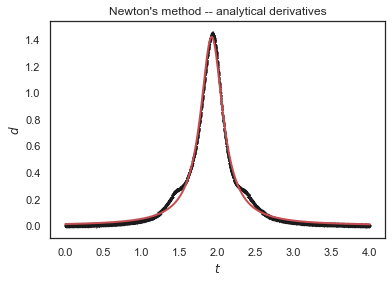

In [941]:
pred = calc_lorentz(params,t)[0]

plt.title("Newton's method -- analytical derivatives")
plt.plot(t,y,c='r',lw=2)
plt.scatter(t,d,marker='.',s=0.1,c='k')
plt.ylabel(r"$d$")
plt.xlabel(r"$t$")
plt.show()

## 1.b)

To estimate the noise in the data, we will do something very similar to what was done in problem set 3. That is, we take the noise squared, or covariance matrix $N$, as being identity times the mean of the data minus our prediction, squared. 

In [722]:
N = np.mean((d-pred)**2)
noise = np.sqrt(N) # let the units guide you
print("The noise in our data is:",noise)

The noise in our data is: 0.02523344255292435


Note that this is the value for all data points. Indeed, in doing so, we are implicitly assuming that the data are independent and with uniform variance. As we will later see, this is not so good at all. 

The errors on the parameters is again found in a straightforward way, i.e. by inverting the left-hand-side of the Newton's method equation $A^T_m N^{-1}A_m \delta_m = A_m^T N^{-1} (d-A(m_0))$, as Jon did in class.

In [723]:
# parameter errors
grad = calc_lorentz(params,t)[1]
lhs = grad.T@grad
par_errs = np.sqrt(N*np.diag(np.linalg.inv(lhs)))
print("The errors are {}".format(par_errs))

The errors are [4.25479046e-04 5.35834556e-05 7.58809724e-05]


At the end of the day, our parameters are therefore

In [724]:
print("a = {} +/- {}".format(params[0],par_errs[0]))
print("t0 = {} +/- {}".format(params[1],par_errs[1]))
print("w = {} +/- {}".format(params[2],par_errs[2]))

a = 1.4228106806318428 +/- 0.00042547904587122423
t0 = 1.9235864937564886 +/- 5.358345563321099e-05
w = 0.1792369079402268 +/- 7.588097244726693e-05


## 1.c)

Now we want to compute the derivatives numerically. To do so, we write a handler function which takes our lorentzian and returns its gradient with respect to all parameters.

Let's use the differentiator from problem set 1 as the heart of our engine (it is the two-point derivative for added accuracy):

In [725]:
def ndiff2(fun,x,dx_ord=0):
    """
    Numerical derivative using both +/- dx and +/- 2*dx
    """
    # this is a fine choice for our purposes:
    # a) Newton's method will keep iterating until the solution is good and
    # b) our function and its derivatives are of order unity
    order = 3 + dx_ord
    dx = 10**(-order)
    
    # compute the function at the points of interest
    yplus = fun(x + dx)
    yminus = fun(x - dx)
    yplus2 = fun(x + 2*dx)
    yminus2 = fun(x - 2*dx)
    
    # compute the numerical derivative
    fprime = (8 * yplus - yplus2 + yminus2 - 8 * yminus) / (12 * dx)
    
    return fprime

In [726]:
def lorentz(t,a,t0,w):
    """
    Simple Lorentzian function
    """
    y = a / (1 + ((t-t0)/w)**2)
    
    return y
    
def params_grad(fun,t,params):
    """
    Returns the numerical derivative at points `params` in parameter space
    """
    a, t0, w = params
    
    # derivative w.r.t a at p
    fun_a = lambda aa: fun(t,aa,t0,w)
    grad_a = ndiff2(fun_a,a)
    
    # derivative w.r.t t0 at p
    fun_t0 = lambda t00: fun(t,a,t00,w)
    grad_t0 = ndiff2(fun_t0,t0)
    
    # derivative w.r.t w at p
    fun_w = lambda ww: fun(t,a,t0,ww)
    grad_w = ndiff2(fun_w,w)

    # transpose to make it match with calc_lorentz
    return np.array([grad_a, grad_t0, grad_w]).T 

In [727]:
def nnewtons_method(p0,t,d,num,print_params=False):
    """
    Numerical derivative version of `newtons_method`
    Runs Newton's method for initial parameter guess p0
    t and d are the time and data, resp.
    """
    # starting parameters is p0
    p = p0.copy()

    for i in range(num):
        # calculate derivatives and function
        a,t0,w = p
        pred = lorentz(t,a,t0,w)
        grad = params_grad(lorentz,t,p)
        
        # delta is difference between data and prediction
        # thanks Jon for the code
        r = d - pred
        err = (r**2).sum()
        r = r.T
        
        lhs=grad.T@grad
        rhs=grad.T@r
        dp=np.linalg.inv(lhs)@(rhs)
        for jj in range(p.size):
            p[jj]=p[jj]+dp[jj]
                        
        if print_params:
            print("The parameters are:",p)
            print("The step is:",dp)
    
    return p, dp

In [728]:
# same num as last time
params_n, dps_n = nnewtons_method(p0=p0,t=t,d=d,num=num,print_params=True)

The parameters are: [0.76785413 1.89433514 0.28446934]
The step is: [-0.23214587 -0.10566486 -0.71553066]
The parameters are: [1.3222158  1.95114333 0.11813508]
The step is: [ 0.55436167  0.05680819 -0.16633426]
The parameters are: [1.35809486 1.92932537 0.179909  ]
The step is: [ 0.03587907 -0.02181796  0.06177392]
The parameters are: [1.42290402 1.92311333 0.17907933]
The step is: [ 0.06480915 -0.00621205 -0.00082967]
The parameters are: [1.42271787 1.92360362 0.17925956]
The step is: [-0.00018615  0.00049029  0.00018023]
The parameters are: [1.42281015 1.92358533 0.17923704]
The step is: [ 9.22812171e-05 -1.82867716e-05 -2.25195558e-05]
The parameters are: [1.42281037 1.92358652 0.17923699]
The step is: [ 2.13613556e-07  1.18840806e-06 -5.01301458e-08]
The parameters are: [1.42281067 1.92358649 0.17923691]
The step is: [ 3.05487824e-07 -2.98513534e-08 -7.70328545e-08]
The parameters are: [1.42281068 1.92358649 0.17923691]
The step is: [ 8.78734101e-09  3.19297271e-09 -2.21597017e-09

In [729]:
# converged values
print("The parameters are:",params_n)
print("The last step is:",dps_n)

The parameters are: [1.42281068 1.92358649 0.17923691]
The last step is: [ 5.89274473e-12  2.22744756e-13 -1.48601868e-12]


The error in our parameters is derived in much the same way, albeit with a different prediction and thus different noise. Let's just run the code again, adding `n` in front of each variable:

In [730]:
# new noise
npred = calc_lorentz(params_n,t)[0]
nN = np.mean((d-npred)**2)

# parameter errors
ngrad = params_grad(lorentz,t,params_n) # use differential gradient
nlhs = ngrad.T@ngrad
par_errs_n = np.sqrt(N*np.diag(np.linalg.inv(nlhs)))
print("The errors are {}".format(par_errs_n))

The errors are [4.25479046e-04 5.35834557e-05 7.58809724e-05]


In [731]:
print("a = {} +/- {}".format(params_n[0],par_errs_n[0]))
print("t0 = {} +/- {}".format(params_n[1],par_errs_n[1]))
print("w = {} +/- {}".format(params_n[2],par_errs_n[2]))

a = 1.4228106806631224 +/- 0.0004254790456739953
t0 = 1.923586493745958 +/- 5.3583455669798896e-05
w = 0.17923690793233896 +/- 7.58809723886368e-05


We see that both methods are indeed consistent! This is of course to be expected.

## 1.d)

We now repeat this process with a slightly better model of three lorentzians, still sticking with our numerical derivatives:
\begin{equation}
d =  \frac{a}{1 + \left(\frac{t-t_0}{\omega}\right)^2} +  \frac{b}{1 + \left(\frac{t-t_0+dt}{\omega}\right)^2} +  \frac{c}{1 + \left(\frac{t-t_0-dt}{\omega}\right)^2}
\end{equation}
in hopes of modelling the little kinks that show up slightly below the FWHM.

In [732]:
def lorentz_3(t,a,b,c,t0,dt,w):
    """
    Model for the three-peaked lorentzian
    """
    y1 = a / (1 + ((t-t0)/w)**2)
    y2 = b / (1 + ((t-t0+dt)/w)**2) 
    y3 = c / (1 + ((t-t0-dt)/w)**2)
    
    return y1+y2+y3

def lorentz_3_p(t,params):
    """
    Model for the three-peaked lorentzian
    takes in params instead of each individual parameter
    """
    a,b,c,t0,dt,w=params
    y1 = a / (1 + ((t-t0)/w)**2)
    y2 = b / (1 + ((t-t0+dt)/w)**2) 
    y3 = c / (1 + ((t-t0-dt)/w)**2)
    
    return y1+y2+y3

def params_grad_3(fun,t,params):
    """
    Returns the numerical derivative at points `params` in parameter space
    """
    a, b, c, t0, dt, w = params
    
    # derivative w.r.t a at p
    fun_a = lambda aa: fun(t,aa,b,c,t0,dt,w)
    grad_a = ndiff2(fun_a,a)
    
    # derivative w.r.t t0 at p
    fun_b = lambda bb: fun(t,a,bb,c,t0,dt,w)
    grad_b = ndiff2(fun_b,b)
    
    # derivative w.r.t w at p
    fun_c = lambda cc: fun(t,a,b,cc,t0,dt,w)
    grad_c = ndiff2(fun_c,c)
    
    # derivative w.r.t w at p
    fun_t0 = lambda t00: fun(t,a,b,c,t00,dt,w)
    grad_t0 = ndiff2(fun_t0,t0)
    
    # derivative w.r.t w at p
    fun_dt = lambda dtt: fun(t,a,b,c,t0,dtt,w)
    grad_dt = ndiff2(fun_dt,dt)
    
    # derivative w.r.t w at p
    fun_w = lambda ww: fun(t,a,b,c,t0,dt,ww)
    grad_w = ndiff2(fun_w,w)

    # transpose to make it match with calc_lorentz
    return np.array([grad_a, grad_b, grad_c, grad_t0, grad_dt, grad_w]).T

In [733]:
# initial parameters
p0_3 = np.array([1,0.2,0.2,2,0.5,0.2])

In [734]:
def nnewtons_method_3(p0,t,d,num,print_params=False):
    """
    Numerical derivative version of `newtons_method`
    Runs Newton's method for initial parameter guess p0
    t and d are the time and data, resp.
    """
    # starting parameters is p0
    p = p0.copy()

    for i in range(num):
        # calculate derivatives and function
        a,b,c,t0,dt,w = p
        pred = lorentz_3(t,a,b,c,t0,dt,w)
        grad = params_grad_3(lorentz_3,t,p)
        
        # delta is difference between data and prediction
        # thanks Jon for the code
        r = d - pred
        err = (r**2).sum()
        r = r.T
        
        lhs=grad.T@grad
        rhs=grad.T@r
        dp=np.linalg.pinv(lhs)@(rhs)
        for jj in range(p.size):
            p[jj]=p[jj]+dp[jj]
                        
        if print_params:
            print("The parameters are:",p)
            print("The step is:",dp)
    
    return p, dp

In [735]:
num_3 = 25 # seems to do the trick!
params_3, dps_3 = nnewtons_method_3(p0=p0_3,t=t,d=d,num=num_3,print_params=True)

The parameters are: [1.25875659 0.03205901 0.05125319 1.88432247 0.47285126 0.19661898]
The step is: [ 0.25875659 -0.16794099 -0.14874681 -0.11567753 -0.02714874 -0.00338102]
The parameters are: [1.37180079 0.08195452 0.02660507 1.93394328 0.44559526 0.17452995]
The step is: [ 0.11304419  0.04989551 -0.02464813  0.04962081 -0.027256   -0.02208903]
The parameters are: [1.43982394 0.10777217 0.07082785 1.92477355 0.42700082 0.15811208]
The step is: [ 0.06802316  0.02581765  0.04422278 -0.00916974 -0.01859444 -0.01641788]
The parameters are: [1.44205621 0.10215355 0.06123417 1.92592106 0.44924194 0.16136805]
The step is: [ 0.00223227 -0.00561862 -0.00959367  0.00114751  0.02224112  0.00325598]
The parameters are: [1.44307903 0.10406581 0.06518901 1.92575537 0.44424686 0.1605438 ]
The step is: [ 0.00102281  0.00191226  0.00395484 -0.00016568 -0.00499508 -0.00082425]
The parameters are: [1.44296118 0.10385718 0.06455757 1.92579343 0.44602098 0.16068572]
The step is: [-1.17846501e-04 -2.0862

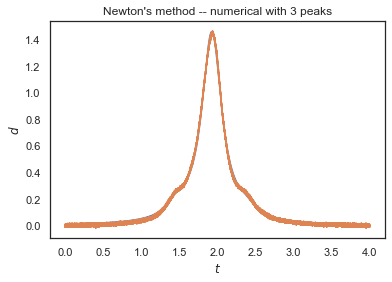

In [943]:
pred_3 = lorentz_3_p(t,params_3)

plt.title("Newton's method -- numerical with 3 peaks")
plt.plot(t,pred_3)
plt.plot(t,d)
plt.ylabel(r"$d$")
plt.xlabel(r"$t$")
plt.show()

In [737]:
N3 = np.mean((d-pred_3)**2)

# parameter errors
grad3 = params_grad_3(lorentz_3,t,params_3) # use differential gradient
lhs3 = grad3.T@grad3
par_errs_3 = np.sqrt(N*np.diag(np.linalg.inv(lhs3)))
print("The errors are {}".format(par_errs_3))

The errors are [4.61217615e-04 4.39904310e-04 4.30740786e-04 5.46062062e-05
 6.58286918e-04 9.77950891e-05]


In [738]:
print("a = {} +/- {}".format(params_3[0],par_errs_3[0]))
print("b = {} +/- {}".format(params_3[1],par_errs_3[1]))
print("c = {} +/- {}".format(params_3[2],par_errs_3[2]))
print("t0 = {} +/- {}".format(params_3[3],par_errs_3[3]))
print("dt = {} +/- {}".format(params_3[4],par_errs_3[4]))
print("w = {} +/- {}".format(params_3[5],par_errs_3[5]))

a = 1.4429923952636599 +/- 0.0004612176148250897
b = 0.10391078247787726 +/- 0.00043990430991299356
c = 0.06473252922179458 +/- 0.0004307407855099515
t0 = 1.9257852184591313 +/- 5.460620617357128e-05
dt = 0.4456716341697543 +/- 0.0006582869183612527
w = 0.16065109386337342 +/- 9.779508906035393e-05


## 1.e)

In [739]:
residuals = pred_3 - d
res_errs = noise # residual errors is simply square root of noise

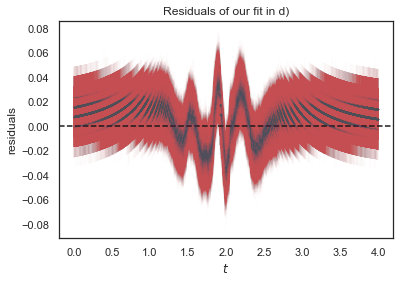

In [944]:
plt.figure()

plt.title("Residuals of our fit in d)")

plt.errorbar(t,residuals,yerr=res_errs,fmt='.',markersize=1,alpha=0.01,ecolor='r')

plt.axhline(y=0,c='k',ls='--')

# plt.scatter(t,residuals,marker='.',s=1,c=r)

plt.ylabel(r"residuals")
plt.xlabel(r"$t$")

plt.show()

The residuals are in blue while the errobars are in red. We can clearly see some oscillatory pattern here, indicating that our model is not a complete representation of the data (we are potentially missing some important physics). We should therefore *not* believe the error bars we got by simply assuming uniform and independent errors.  

## 1. f)

We would now like to explore near our ideal parameters and plot some fits by using the full covariance matrix $(A^T N^{-1} A)^{-1}=$`np.linalg.inv(lhs3)`. 

In [750]:
# full covariance matrix
cov_3 = np.linalg.inv(lhs3) 

# generate some new fits near the ideal ones
num_other = 100
other_preds = np.zeros((num_other,t.size),dtype=float)
for i in range(num_other):
    # generate the new parameters
    other_params = np.random.multivariate_normal(params_3,cov_3)
    # what is the curve?
    other_preds[i,:] = lorentz_3_p(t,other_params)

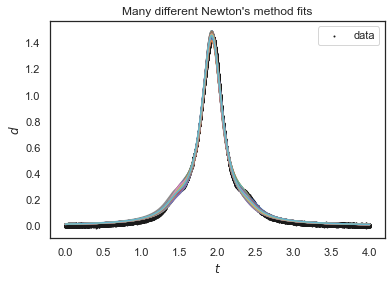

In [949]:
plt.figure()

plt.title("Many different Newton's method fits")

plt.scatter(t,d,s=1,c='k',label='data')
for i in range(num_other):
    plt.plot(t,other_preds[i,:])
    
plt.ylabel(r"$d$")
plt.xlabel(r"$t$")
plt.legend()
plt.show()

Check that there is indeed some differen between the two:

In [753]:
print(params_3-other_params)

[-7.28129222e-05  2.14463948e-02  1.53889177e-02  2.94655515e-03
 -2.87616565e-02 -7.24783304e-03]


There is! Now, how does the $\chi^2$ of each new fit compare to our optimal fit?

In [817]:
def chisquared(d,pred,errs):
    """
    Computes chi-squared given some data d and pred
    In our case, errs is a constant and is always the same
    """
    chi2 = np.sum((pred-d)**2/errs**2)
    
    return chi2

In [818]:
# compute the chi^2 of other fits
chisquared_others = np.array([chisquared(d,other_preds[i,:],noise) for i in range(num_other)])

# compute the mean of the difference between our optimal chi^2 and the others
typical_difference = np.mean(chisquared(d,pred_3,noise)-chisquared(d,other_preds,noise))
print("Typical differen in chi^2 is: {}".format(typical_difference))

Typical differen in chi^2 is: -4202181.895480522


It is negative, since our optimal parameters have a smaller $\chi^2$ (better fit) than other sets of parameters near these points, as expected!. Note moreover that the optimal parameters $\chi^2$ (shown in red below) is lower than all others, again as expected!

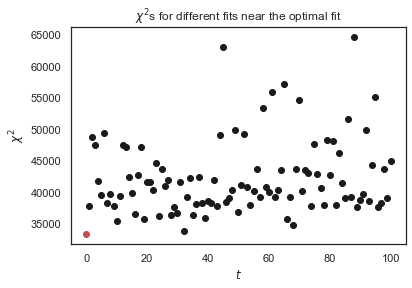

In [951]:
plt.figure()

plt.title(r"$\chi^2$s for different fits near the optimal fit")

plt.scatter(0,chisquared(d,pred_3,noise),c='r')
for i in range(num_other):
    plt.scatter(i+1,chisquared(d,other_preds[i,:],noise),c='k')
    
plt.ylabel(r"$\chi^2$")
plt.xlabel(r"$t$")

plt.show()

## 1. g)

Now, we would like to redo the fit using an MCMC algorithm. 

In [918]:
def random_step(cov):
    """
    Random Gaussian step in each parameter
    """
    scale = 0.9
    
    cov = cov/scale
    
    step = np.random.multivariate_normal(np.zeros(cov.shape[0]),cov)
    
    return step
    
def mcmc_step(params,chisq,cov,errs):
    """
    Single step in MCMC chain
    Params is a vector 
    Param_errs is the covariance in the initial parameters in the 
    """
    # compute a set of new trial parameters 
    new_params = params + random_step(cov)
    
    # they predict the following data
    new_pred = lorentz_3_p(t,new_params)
    
    # this data has the following chi squared
    new_chisq = chisquared(d,new_pred,errs)
    
    # if it improves the chi squared, always accept
    # if not, accept it with a probability exp(-1/2* ((x^2)new - (x^2)old))
    log_accept_prob = -1/2*(new_chisq - chisq)
    
    # make it a log to avoid computing exponentials
    if np.log(np.random.rand(1)) < log_accept_prob:
        return new_params, new_chisq
    else:
        return params, chisq
    
def mcmc_main(t,d,initial_params,cov,errs,nstep=20000):
    """
    Main function for the MCMC chain
    """
    # initialize chain
    n = initial_params.size
    chain_params = np.zeros((nstep,n),dtype=float)
    chain_params[0,:] = initial_params
    
    # compute initial chi squared
    pred = lorentz_3_p(t,initial_params)
    initial_chisq = chisquared(d,pred,errs)
    chain_chisq = np.zeros(nstep,dtype=float)
    chain_chisq[0] = initial_chisq
            
    # take `nstep` number of steps
    for i in range(1,nstep):
        # get the old parameters
        params = chain_params[i-1,:]
        chisq = chain_chisq[i-1]
        # compute the putative new ones
        params_, chisq_ = mcmc_step(params,chisq,cov,errs)
        # put them into the chain
        chain_params[i,:] = params_
        chain_chisq[i] = chisq_
        
    return chain_params, chain_chisq

In [924]:
initial_params = p0_3

nsteps = 20000

chain_params, chain_chisq = mcmc_main(t,d,initial_params,cov_3,noise,nstep=nsteps)

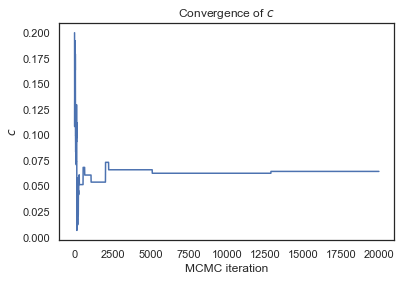

In [952]:
plt.figure()

plt.title(r"Convergence of $c$")

plt.plot(np.arange(nsteps),chain_params[:,2])

plt.ylabel(r"$c$")
plt.xlabel(r"MCMC iteration")

plt.show()

It seems to have converged. To find the errors on each parameter, we simply calculate the covariance of the chain. We can chop out the burn-in period, which happens up until $\sim 2500$ steps.

In [974]:
burnin = 2500
param_errs_mcmc = np.std(chain_params[burnin:,:],axis=0)

Our best parameters are:

In [975]:
params_mcmc = chain_params[-1,:]

print("a = {} +/- {}".format(params_mcmc[0],param_errs_mcmc[0]))
print("b = {} +/- {}".format(params_mcmc[1],param_errs_mcmc[1]))
print("c = {} +/- {}".format(params_mcmc[2],param_errs_mcmc[2]))
print("t0 = {} +/- {}".format(params_mcmc[3],param_errs_mcmc[3]))
print("dt = {} +/- {}".format(params_mcmc[4],param_errs_mcmc[4]))
print("w = {} +/- {}".format(params_mcmc[5],param_errs_mcmc[5]))

a = 1.4408067061131538 +/- 0.0003575025991260244
b = 0.1043948532665454 +/- 0.0029758376912612234
c = 0.06437626666566036 +/- 0.001228108764122675
t0 = 1.926168926942645 +/- 0.00044399988342391826
dt = 0.44199300313834083 +/- 0.0027613838049588557
w = 0.16109836884720874 +/- 0.000219611950597881


These are all consistent with our previosuly obtained parameters, except for $a$. Our error bars did indeed change when compared to the previous 3-peaked numerical Newton's method! They all got much larger.

Plot the fit to make sure we have good parameters:

In [976]:
pred_mcmc = lorentz_3_p(t,params_mcmc)

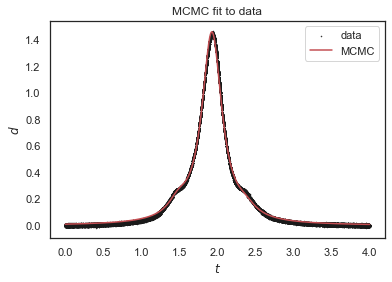

In [977]:
plt.figure()

plt.title("MCMC fit to data")

plt.scatter(t,d,marker='.',s=1,c='k',label='data')
plt.plot(t,pred_mcmc,c='r',label='MCMC')
plt.ylabel(r"$d$")
plt.xlabel(r"$t$")
plt.legend()
plt.show()

## 1.h)

The width of the cavity resonance is the parameter `w`, or $w$. Taking $dt \rightarrow 9 \mathrm{GHz}$, we can solve for the true width $w_{true}$ via
\begin{equation}
\frac{9 GHz}{w_{true}}=\frac{dt}{w}.
\end{equation}
This yields

In [978]:
# important! un-scale from beginning
dt_mcmc = params_mcmc[4] / 1e4
w_mcmc = params_mcmc[5] / 1e4

# compute the value
w_true = 9*w_mcmc/dt_mcmc

In [990]:
# errors are found via monte carlo method
# we just generate a large normal sampe and compute its np.std
w_mcmc_m = np.random.normal(loc=w_mcmc,scale=param_errs_mcmc[5]/1e4,size=10000) # careful with the scales
dt_mcmc_m = np.random.normal(loc=dt_mcmc,scale=param_errs_mcmc[4]/1e4,size=10000)

w_true_m = 9*w_mcmc_m/dt_mcmc_m
w_true_err = np.std(w_true_m)

In [991]:
print("The actual width of the cavity resonance is {:.3} +/- {:.1} GHz".format(w_true,w_true_err))

The actual width of the cavity resonance is 3.28 +/- 0.02 GHz
